In [1]:
%reset -fs

In [2]:
import pandas as pd
import numpy as np
import string
import re
import spacy
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from corextopic import corextopic as ct
from corextopic import vis_topic as vt
from matplotlib import pyplot as plt
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import minmax_scale
import seaborn as sns
%matplotlib inline

C:\Users\nated\anaconda3\lib\site-packages\matplotlib_inline\config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [3]:
stop_words = text.ENGLISH_STOP_WORDS.union(['nof', 'nthe', 'nand', 'nto', 'nin', 'nit', 'nfor', 'na', 'nthat', 'nbe', 'applause', 'nwhich', 'nis', 'nare', 'ni', 'nnot', 'nby', 'nhave', 'nbut', 'nwe', 'nwith', 'nfrom', 'nwill', 'nhas', 'nan', 'nif', 'nour', 'americans', 'america', 'american', 'government', 'united', 'states', 'public', 'country', 'state', 'nation', 'people', 'year', 'congress', 'national', 'great'])

In [4]:
df = pd.read_csv('sotu_texts.csv')
df

,President,Year,Title,Text
0,George Washington,1790,First State of the Union Address,['I embrace with great satisfaction the opport...
1,George Washington,1790,Second State of the Union Address,['Fellow-Citizens of the Senate and the House ...
2,George Washington,1791,Third State of the Union Address,['Fellow-Citizens of the Senate and the House ...
3,George Washington,1792,Fourth State of the Union Address,['Fellow-Citizens of the Senate and of the Hou...
4,George Washington,1793,Fifth State of the Union Address,['Fellow Citizens of the Senate and of the Hou...
...,...,...,...,...
215,Barack Obama,2016,Barack Obama's Eighth State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ..."
216,Donald Trump,2017,Donald Trump's First State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ..."
217,Donald Trump,2018,Donald Trump's Second State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ..."
218,Donald Trump,2019,Donald Trump's Third State of the Union Address,"['Madam Speaker, Mr. Vice President, Members o..."


In [5]:
alphanumeric = lambda x: re.sub(r'\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

df['new_text'] = df.Text.map(alphanumeric).map(punc_lower)

In [6]:
nlp = spacy.load("en_core_web_sm")
docs = nlp.pipe(df.Text)

In [7]:
docs_clean = [[w.lemma_.lower() for w in doc if (not w.is_stop and not w.is_punct and not w.like_num)] for doc in docs]
df['docs_clean'] = docs_clean

In [8]:
docs_list_clean = [' '.join(doc) for doc in docs_clean]


In [9]:
count_vec = CountVectorizer(stop_words=stop_words, ngram_range=(1,3), min_df=2, max_df=219)
count_vec_X = count_vec.fit_transform(docs_list_clean)

In [10]:
num_topics = 10
SVD_topics = TruncatedSVD(num_topics)
doc_topic = SVD_topics.fit_transform(count_vec_X)

In [11]:
topic_word = pd.DataFrame(SVD_topics.components_.round(3),
             columns = count_vec.get_feature_names_out())

In [12]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [13]:
display_topics(SVD_topics, count_vec.get_feature_names_out(), 10)


Topic  0
law, time, war, increase, power, new, work, present, act, service

Topic  1
program, world, new, need, federal, help, economic, work, administration, security

Topic  2
war, program, dollar, fiscal, mexico, expenditure, policy, estimate, continue, increase

Topic  3
dollar, service, legislation, department, man, law, court, fiscal, increase, expenditure

Topic  4
war, dollar, expenditure, man, fiscal, good, estimate, business, wage, peace

Topic  5
man, mexico, power, war, peace, policy, force, constitution, right, union

Topic  6
mexico, texas, mexican, army, war, foreign, canal, department, court, business

Topic  7
gold, world, free, war, silver, peace, mexico, note, island, bond

Topic  8
world, free, department, shall, canal, war, military, force, power, peace

Topic  9
island, act, cuba, war, spain, provide, general, treaty, spanish, dollar


In [14]:
tfidf_vec = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,3), min_df=2, max_df=219)
tfidf_X = tfidf_vec.fit_transform(docs_list_clean)

In [15]:
doc_topic = SVD_topics.fit_transform(tfidf_X)

In [16]:
display_topics(SVD_topics, tfidf_vec.get_feature_names_out(), 10)


Topic  0
law, time, new, power, war, present, world, work, increase, shall

Topic  1
job, world, tonight, help, program, new, work, child, let, need

Topic  2
program, economic, federal, world, problem, increase, farm, development, method, need

Topic  3
work, cent, law, court, department, business, silver, secretary, commission, report

Topic  4
man, war, interstate, corporation, enemy, law, business, fight, industrial, good

Topic  5
war, world, fight, man, enemy, mexico, soviet, free, nations, freedom

Topic  6
iraq, terrorist, iraqi, terror, al, weapon, regime, enemy, militia, saddam

Topic  7
terrorist, iraq, mexico, iraqi, bank, al, enemy, terror, texas, war

Topic  8
war, gold, silver, job, cent, know, nations, treasury, production, japanese

Topic  9
spain, job, war, british, colony, island, construction, territory, treaty, coast


In [17]:
LDA_topics = LatentDirichletAllocation(n_components=10)

In [18]:
count_vec_X = count_vec.fit_transform(docs_list_clean)

In [19]:
doc_topic = LDA_topics.fit_transform(count_vec_X)

In [20]:
display_topics(LDA_topics, count_vec.get_feature_names_out(), 10)


Topic  0
mark character, ravage war, impracticable execution, remain remain, expect render, day comprehensive, hold fully, peace new, peace seek, birth come

Topic  1
law, present, service, time, general, increase, man, power, condition, work

Topic  2
law, peace, war, power, shall, time, necessary, man, service, present

Topic  3
act war, dictator, armistice, capture british, command captain, french decree, repeal order, population resource, impressive, world freedom

Topic  4
cut, thing, health care, lot, ought, work, covenant, deficit, think, care

Topic  5
world, new, work, need, time, program, war, help, federal, increase

Topic  6
saddam hussein, hussein, saddam, inspector, disarm, aids, weapon, north korean, biological, hide

Topic  7
mark character, ravage war, impracticable execution, remain remain, expect render, day comprehensive, hold fully, peace new, peace seek, birth come

Topic  8
inch, mortar, inch inch, high power, deficit, emplacement, penitentiary, gun, save lose, 

In [21]:
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(LDA_topics, count_vec_X, count_vec, mds='mmds')

C:\Users\nated\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\nated\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.244672  0.038832       1        1  36.062285
5     -0.095389 -0.247180       2        1  32.691028
9     -0.242980 -0.060781       3        1  28.054619
2     -0.113598  0.110676       4        1   2.578841
4      0.136336 -0.020770       5        1   0.269187
8      0.136457  0.046102       6        1   0.178092
6      0.107824  0.049393       7        1   0.089393
3      0.106394  0.021568       8        1   0.072334
0      0.104818  0.031058       9        1   0.002110
7      0.104809  0.031102      10        1   0.002110, topic_info=                     Term         Freq        Total Category  logprob  loglift
23924                 cut   404.000000   404.000000  Default  30.0000  30.0000
79189             program  1145.000000  1145.000000  Default  29.0000  29.0000
110822               work  2602.000000  2602.000000  Default  28.0000  28.0000
55630                 law  3321.000000  3321.000000  Default  27.0000  27.0000
72246               peace  1710.000000  1710.000000  Default  26.0000  26.0000
...                   ...          ...          ...      ...      ...      ...
24306            day join     0.000196     3.299822  Topic10 -11.6279   1.0352
99650     success failure     0.000196     8.124101  Topic10 -11.6279   0.1343
1365             act lead     0.000196     2.335545  Topic10 -11.6279   1.3809
1908    actually bear arm     0.000196     2.335660  Topic10 -11.6279   1.3808
67747     number actually     0.000196     2.335660  Topic10 -11.6279   1.3808

[775 rows x 6 columns], token_table=        Topic      Freq             Term
term                                    
665         4  0.823359  accomplish time
848         3  0.208691  account receipt
848         4  0.626072  account receipt
891         3  0.606774  accumulate fund
1129        1  0.360689              act
...       ...       ...              ...
111436      4  0.003757            world
111601      2  0.990042    world freedom
111820      3  0.668419       world term
111854      2  0.996858        world war
112002      1  0.997405       wrongdoing

[1207 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 10, 3, 5, 9, 7, 4, 1, 8])

In [22]:
tfidf_X = tfidf_vec.fit_transform(docs_list_clean)

In [23]:
doc_topic = LDA_topics.fit_transform(tfidf_X)

In [24]:
display_topics(LDA_topics, tfidf_vec.get_feature_names_out(), 10)


Topic  0
weapon development, nuclear weapon development, send propose, command control, iran continue, international food, generate energy, alliance world, economic stagnation, major research

Topic  1
law, time, world, new, war, power, work, present, increase, shall

Topic  2
weapon development, nuclear weapon development, send propose, command control, iran continue, international food, generate energy, alliance world, economic stagnation, major research

Topic  3
weapon development, nuclear weapon development, send propose, command control, iran continue, international food, generate energy, alliance world, economic stagnation, major research

Topic  4
weapon development, nuclear weapon development, send propose, command control, iran continue, international food, generate energy, alliance world, economic stagnation, major research

Topic  5
weapon development, nuclear weapon development, send propose, command control, iran continue, international food, generate energy, alliance wo

In [25]:
pyLDAvis.sklearn.prepare(LDA_topics, tfidf_X, tfidf_vec, mds='mmds')

C:\Users\nated\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\nated\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.037530  0.013079       1        1  97.894092
0     -0.004171 -0.001452       2        1   0.233990
2     -0.004170 -0.001453       3        1   0.233990
3     -0.004171 -0.001451       4        1   0.233990
4     -0.004169 -0.001455       5        1   0.233990
5     -0.004171 -0.001452       6        1   0.233990
6     -0.004170 -0.001454       7        1   0.233990
7     -0.004170 -0.001453       8        1   0.233990
8     -0.004170 -0.001454       9        1   0.233990
9     -0.004169 -0.001457      10        1   0.233990, topic_info=                    Term      Freq     Total Category  logprob  loglift
23924                cut  1.000000  1.000000  Default  30.0000  30.0000
87781           republic  1.000000  1.000000  Default  29.0000  29.0000
50495           industry  1.000000  1.000000  Default  28.0000  28.0000
6582             article  1.000000  1.000000  Default  27.0000  27.0000
63408           minister  1.000000  1.000000  Default  26.0000  26.0000
...                  ...       ...       ...      ...      ...      ...
68228     objective seek  0.000191  0.053573  Topic10 -11.6279   0.4224
78569     problem manage  0.000191  0.053573  Topic10 -11.6279   0.4224
83379       reach dollar  0.000191  0.053573  Topic10 -11.6279   0.4224
97102   speed industrial  0.000191  0.053573  Topic10 -11.6279   0.4224
102615        think plan  0.000191  0.053573  Topic10 -11.6279   0.4224

[600 rows x 6 columns], token_table=        Topic      Freq            Term
term                                   
1129        1  0.898640             act
6582        1  0.791752         article
9617        1  0.776390         benefit
11006       1  0.768926         british
13468       1  0.782175         certain
14880       1  0.961846         citizen
17242       1  0.762167      commercial
22781       1  0.797121          course
23155       1  0.811324          create
23924       1  0.787088             cut
25998       1  1.151324      department
27115       1  0.800593     development
29479       1  0.993021            duty
32617       1  0.818600          energy
38627       1  0.817417         federal
40122       1  0.803955           force
42557       1  1.069156         general
43328       1  0.911528            good
45568       1  1.092300            help
46412       1  0.757515            hold
48162       1  0.814542      importance
49348       1  1.106646        increase
50495       1  0.784861        industry
52986       1  0.779222           issue
53320       1  0.804872             job
53806       1  0.808306            june
55630       1  1.068850             law
57945       1  0.755292            like
58239       1  0.755801            line
59863       1  0.767592            make
60053       1  1.111539             man
63408       1  0.782820        minister
65320       1  1.181171       necessary
65731       1  0.919950            need
66428       1  0.897924             new
72246       1  0.990548           peace
75327       1  0.755157        possible
75680       1  0.997622           power
76745       1  1.027209         present
79189       1  0.979748         program
80166       1  0.809223        property
80757       1  0.780079         protect
81158       1  0.817816         provide
87781       1  0.788394        republic
88499       1  0.803734        resource
88821       1  0.803070  responsibility
90115       1  0.966512           right
92941       1  0.794397            seek
93654       1  1.062547         service
94466       1  0.860886           shall
98670       1  0.761839          strong
98935       1  0.932418         subject
99340       1  0.810159          submit
100085      1  0.801957             sum
102566      1  0.805909           think
102906      1  1.070451            time
104897      1  1.102922          treaty
108887      1  0.938223             war
110822  

In [26]:
doc_word = count_vec.fit_transform(docs_list_clean)
words = list(np.asarray(count_vec.get_feature_names_out()))

In [27]:
topic_model = ct.Corex(n_hidden=10, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=docs_list_clean)

In [28]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: custom,make,rigidly,postage,postmaster,benefit,favorable consideration,expend,postmaster general,aggregate
1: clause,convinced,organization,value,product,outlet,investigation,topic,absence,condemn
2: far concern,await,dangerous,domestic,announce,imminent,administration justice,duty place,attention direct,head
3: tonight,decade,speaker,deficit,consideration,help,job,nuclear,provision,technology
4: opinion,vest,network,coalition,iran,regard,practicable,iraq,arrangement,modernize
5: court district,thrift,guard,increase funding,crush,express opinion,insufficient,remain quarter,age,cut cost
6: big,remember,report postmaster,report postmaster general,hard,ahead,sharing,worker,develop,new technology
7: useful,small business,article,missouri,salutary,role,permanent,beneficial result,occur,satisfactory
8: accede,sword,early action,time recommend,sagacity,legislate,invalid,england france,necessity exist,difficult
9: ought,scourge,commonly,view,perspective,straits,effect,secure citizen,long wa

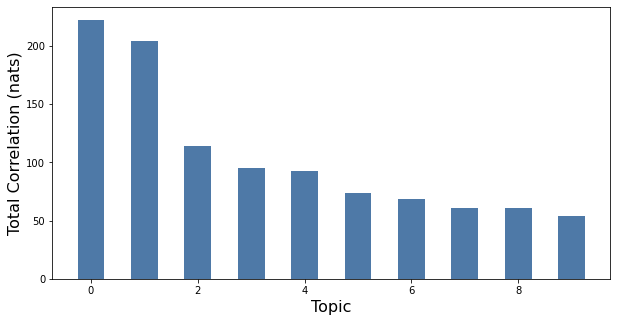

In [29]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [30]:
topic_model = ct.Corex(n_hidden=10, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=docs_list_clean, anchors=[['economy', 'job', 'work', 'program', 'employment'], ['manufacturing', 'production', 'build', 'commerce', 'business', 'farmer', 'agriculture', 'crop', 'private business', 'farm', 'land'], ['government', 'america', 'american', 'people', 'constitution', 'country', 'congress', 'united', 'people', 'nation', 'federal'], ['money', 'expenditure', 'tax', 'fiscal', 'treasury', 'stimulus', 'income', 'dollar', 'currency', 'tariff', 'debt', 'cent', 'bank', 'home'], ['protest', 'race', 'movement', 'strike', 'black', 'indian', 'latino', 'slave', 'civil','right','liberty', 'immigration', 'mexico', 'dreamer', 'citizenship'], ['germany', 'france', 'spain', 'nato', 'europe', 'hitler', 'japan', 'japanese', 'nazi', 'putin', 'ukraine', 'korea', 'soviet', 'ukraine', 'british', 'cuba', 'venezuela', 'iran', 'china', 'russia', 'canada', 'war', 'fight', 'vietnam', 'alliance', 'adversary', 'enemy', 'international', 'german', 'navy', 'military', 'troop', 'sea power', 'admiral', 'general', 'iraqi', 'iraq', 'insurgent', 'terrorist', 'saddam', 'kuwait', 'syria', 'israel', 'panama', 'army', 'peace', 'afghanistan', 'al qaeda', 'taliban', 'islamic', 'defense', 'treaty'], ['energy', 'atomic', 'renewable', 'oil', 'research', 'science', 'innovation', 'cyber', 'space', 'moon', 'rocket', 'cancer', 'health', 'industrial', 'pandemic'], ['law', 'order', 'court', 'crime', 'gang', 'police', 'safe', 'gun', 'sedition', 'communist', 'communism'], ['college', 'school', 'education', 'degree', 'math', 'student',  'education', 'university'], ['road', 'bridge', 'airplane', 'interstate', 'airport', 'highway', 'port', 'dock', 'shipyard', 'railway', 'infrastructure']], anchor_strength=2)

In [31]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: program,job,economic,today,budget,help,goal,ahead,basic,worker
1: crop,farmer,agriculture,farm,method,production,business,department commerce,type,interstate commerce
2: constitution,outbreak,federal,supreme,amendment,service law,countryman,election,money order,total
3: cent,tariff,fiscal,expenditure,currency,treasury,end june,suggestion,postmaster,fiscal end
4: mexico,civil,protest,movement,immigration,slight,indian,citizenship,purely,lay senate
5: cuba,navy,army,japanese,consent,france,spain,rico,officer,panama
6: research,technology,decade,achieve,challenge,environment,small business,cancer,leader,big
7: court,hold,dangerous,perpetuity,commissioners district,department end,british north,fictitious,department end june,end june estimate
8: school,student,education,college,university,math,street,teacher,medicare,tax credit
9: interstate,railway,criminal,highway,commission appoint,colorado,consular service,naturalization,sign,bridge


In [32]:
vt.vis_rep(topic_model, column_label=words, prefix='sotu-model')

Print topics in text file


C:\Users\nated\anaconda3\lib\site-packages\fontTools\misc\py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


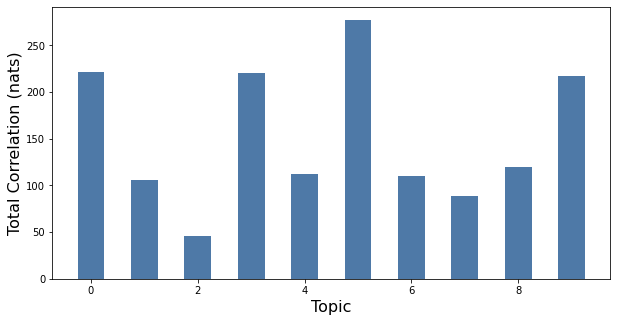

In [33]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);
plt.savefig('topic_graph.png')

In [34]:
predictions = pd.DataFrame(topic_model.log_p_y_given_x, columns=['Economy/Labor', 'Economy/Manufacturing', 'Government/Federalism/States', 'Finances/Budget', 'Social Issues', 'Foreign Policy', 'Science and Technology', 'Crime/Law/Jurisprudence', 'Education', 'Infrastructure'])
predictions['top_topics']=predictions.idxmax(axis=1)
predictions


,Economy/Labor,Economy/Manufacturing,Government/Federalism/States,Finances/Budget,Social Issues,Foreign Policy,Science and Technology,Crime/Law/Jurisprudence,Education,Infrastructure,top_topics
0,-582.920641,-366.070029,-174.166767,-1166.412095,-389.609258,-855.160978,-349.970607,-268.902013,-411.318485,-663.265367,Government/Federalism/States
1,-846.079218,-362.558663,-170.681581,-1073.300328,-391.474873,-853.856135,-369.521567,-264.675237,-412.412958,-659.804809,Government/Federalism/States
2,-1576.031647,-331.953000,-190.008321,-913.661634,-370.365902,-849.339635,-576.963001,-283.650624,-402.638127,-644.153725,Government/Federalism/States
3,-1401.809041,-354.860243,-218.087589,-933.257187,-336.245081,-855.237915,-497.034060,-266.965036,-416.419304,-654.521533,Government/Federalism/States
4,-1165.072027,-358.934307,-167.023565,-953.590406,-363.362968,-825.466865,-362.954020,-270.518631,-418.387965,-648.945098,Government/Federalism/States
...,...,...,...,...,...,...,...,...,...,...,...
215,0.000000,-409.893990,-190.587653,-1104.051714,0.000000,-832.076679,0.000000,-383.527859,0.000000,-651.076414,Economy/Labor
216,0.000000,-398.460882,-149.932825,-1164.446085,0.000000,-827.604363,0.000000,-259.629849,0.000000,0.000000,Economy/Labor
217,0.000000,-398.037303,0.000000,-1168.530760,-363.083518,0.000000,0.000000,0.000000,0.000000,-620.615962,Economy/Labor
218,0.000000,0.000000,-197.866802,-1058.844979,-389.501378,-798.097604,0.000000,0.000000,0.000000,-601.156828,Economy/Labor


In [35]:
df['top_topic'] = predictions.top_topics

In [36]:
df

,President,Year,Title,Text,new_text,docs_clean,top_topic
0,George Washington,1790,First State of the Union Address,['I embrace with great satisfaction the opport...,i embrace with great satisfaction the opport...,"[embrace, great, satisfaction, opportunity, pr...",Government/Federalism/States
1,George Washington,1790,Second State of the Union Address,['Fellow-Citizens of the Senate and the House ...,fellow citizens of the senate and the house ...,"[fellow, citizens, senate, house, representati...",Government/Federalism/States
2,George Washington,1791,Third State of the Union Address,['Fellow-Citizens of the Senate and the House ...,fellow citizens of the senate and the house ...,"[fellow, citizens, senate, house, representati...",Government/Federalism/States
3,George Washington,1792,Fourth State of the Union Address,['Fellow-Citizens of the Senate and of the Hou...,fellow citizens of the senate and of the hou...,"[fellow, citizens, senate, house, representati...",Government/Federalism/States
4,George Washington,1793,Fifth State of the Union Address,['Fellow Citizens of the Senate and of the Hou...,fellow citizens of the senate and of the hou...,"[fellow, citizens, senate, house, representati...",Government/Federalism/States
...,...,...,...,...,...,...,...
215,Barack Obama,2016,Barack Obama's Eighth State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ...",mr speaker mr vice president members of ...,"[mr., speaker, mr., vice, president, members, ...",Economy/Labor
216,Donald Trump,2017,Donald Trump's First State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ...",mr speaker mr vice president members of ...,"[mr., speaker, mr., vice, president, members, ...",Economy/Labor
217,Donald Trump,2018,Donald Trump's Second State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ...",mr speaker mr vice president members of ...,"[mr., speaker, mr., vice, president, members, ...",Economy/Labor
218,Donald Trump,2019,Donald Trump's Third State of the Union Address,"['Madam Speaker, Mr. Vice President, Members o...",madam speaker mr vice president members o...,"[madam, speaker, mr., vice, president, members...",Economy/Labor


In [37]:
predictions_scaled = minmax_scale(np.array(predictions.drop(columns=['top_topics']).values.T)).T
preds_df = pd.DataFrame(predictions_scaled, columns=['Economy/Labor', 'Economy/Manufacturing', 'Government/Federalism/States', 'Finances/Budget', 'Social Issues', 'Foreign Policy', 'Science and Technology', 'Crime/Law/Jurisprudence', 'Education', 'Infrastructure'])
mtx = preds_df.values

In [38]:
maren = KMeans(n_clusters=10, random_state=42)

In [39]:
maren.fit(mtx)

KMeans(n_clusters=10, random_state=42)

In [40]:
preds_df['Cluster'] = maren.labels_

In [41]:
preds_df.Cluster.value_counts()

1    78
2    37
6    23
4    23
0    16
3    13
7    11
8    11
9     5
5     3
Name: Cluster, dtype: int64

In [42]:
df_clusters = preds_df.groupby(['Cluster']).median()
df_clusters

,Economy/Labor,Economy/Manufacturing,Government/Federalism/States,Finances/Budget,Social Issues,Foreign Policy,Science and Technology,Crime/Law/Jurisprudence,Education,Infrastructure
Cluster,,,,,,,,,,
0,1.0,0.872807,0.828195,0.000000,0.619155,0.158625,0.390548,0.696109,0.599410,0.348046
1,0.0,0.899833,1.000000,1.000000,1.000000,1.000000,0.717451,1.000000,0.827194,0.873940
2,1.0,0.657811,0.813130,0.000000,0.643239,0.198904,1.000000,0.758423,1.000000,0.409367
3,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.834122,1.000000,1.000000
4,1.0,0.672170,0.761065,0.000000,0.622999,0.099175,1.000000,0.710953,0.472338,0.367543
5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.0,0.900893,1.000000,0.477892,0.899350,0.558161,0.789895,0.943160,0.834494,0.674393
7,1.0,1.000000,0.724986,1.000000,0.566879,0.000000,1.000000,0.601352,0.516803,1.000000
8,1.0,0.629477,0.810369,0.000000,0.662128,1.000000,1.000000,0.778446,1.000000,0.407287


In [43]:
[[num[0] for num in df_clusters.iloc[1].values.reshape(-1, 1).tolist()]]

[[0.0,
  0.8998330315171807,
  1.0,
  1.0,
  0.9999999999999999,
  0.9999999999999999,
  0.717450887295137,
  1.0,
  0.8271940903998498,
  0.8739396591839026]]

In [44]:
top_3_docs = pairwise_distances([[num[0] for num in df_clusters.iloc[1].values.reshape(-1, 1).tolist()]], \
                                mtx,metric='euclidean').argsort()[0, :3]
df['Cluster']=maren.labels_

In [45]:
df.iloc[top_3_docs[2]]

President                                        Andrew Jackson
Year                                                       1836
Title                         Eighth State of the Union Address
Text          ['Fellow Citizens of the Senate and of the Hou...
new_text        fellow citizens of the senate and of the hou...
docs_clean    [fellow, citizens, senate, house, representati...
top_topic                          Government/Federalism/States
Cluster                                                       1
Name: 44, dtype: object

In [46]:
preds_df.iloc[top_3_docs[2]]

Economy/Labor                   0.000000
Economy/Manufacturing           0.817426
Government/Federalism/States    1.000000
Finances/Budget                 1.000000
Social Issues                   1.000000
Foreign Policy                  1.000000
Science and Technology          0.727567
Crime/Law/Jurisprudence         1.000000
Education                       0.798388
Infrastructure                  0.725070
Cluster                         1.000000
Name: 44, dtype: float64

In [47]:
dfs = [df.drop(columns=['Cluster']), preds_df]
df_1 = pd.concat(dfs, axis=1)

In [48]:
df_1

,President,Year,Title,Text,new_text,docs_clean,top_topic,Economy/Labor,Economy/Manufacturing,Government/Federalism/States,Finances/Budget,Social Issues,Foreign Policy,Science and Technology,Crime/Law/Jurisprudence,Education,Infrastructure,Cluster
0,George Washington,1790,First State of the Union Address,['I embrace with great satisfaction the opport...,i embrace with great satisfaction the opport...,"[embrace, great, satisfaction, opportunity, pr...",Government/Federalism/States,0.588052,0.806597,1.000000,0.000000,0.782874,0.313684,0.822822,0.904524,0.760995,0.507079,2
1,George Washington,1790,Second State of the Union Address,['Fellow-Citizens of the Senate and the House ...,fellow citizens of the senate and the house ...,"[fellow, citizens, senate, house, representati...",Government/Federalism/States,0.251735,0.787422,1.000000,0.000000,0.755386,0.243119,0.779708,0.895866,0.732189,0.458107,6
2,George Washington,1791,Third State of the Union Address,['Fellow-Citizens of the Senate and the House ...,fellow citizens of the senate and the house ...,"[fellow, citizens, senate, house, representati...",Government/Federalism/States,0.000000,0.897589,1.000000,0.477892,0.869874,0.524300,0.720817,0.932438,0.846590,0.672339,6
3,George Washington,1792,Fourth State of the Union Address,['Fellow-Citizens of the Senate and of the Hou...,fellow citizens of the senate and of the hou...,"[fellow, citizens, senate, house, representati...",Government/Federalism/States,0.000000,0.884455,1.000000,0.395829,0.900181,0.461740,0.764348,0.958709,0.832451,0.631304,6
4,George Washington,1793,Fifth State of the Union Address,['Fellow Citizens of the Senate and of the Hou...,fellow citizens of the senate and of the hou...,"[fellow, citizens, senate, house, representati...",Government/Federalism/States,0.000000,0.807714,1.000000,0.211895,0.803277,0.340269,0.803686,0.896303,0.748144,0.517136,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,Barack Obama,2016,Barack Obama's Eighth State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ...",mr speaker mr vice president members of ...,"[mr., speaker, mr., vice, president, members, ...",Economy/Labor,1.000000,0.628737,0.827374,0.000000,1.000000,0.246343,1.000000,0.652618,1.000000,0.410284,2
216,Donald Trump,2017,Donald Trump's First State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ...",mr speaker mr vice president members of ...,"[mr., speaker, mr., vice, president, members, ...",Economy/Labor,1.000000,0.657811,0.871241,0.000000,1.000000,0.289272,1.000000,0.777036,1.000000,1.000000,2
217,Donald Trump,2018,Donald Trump's Second State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ...",mr speaker mr vice president members of ...,"[mr., speaker, mr., vice, president, members, ...",Economy/Labor,1.000000,0.659369,1.000000,0.000000,0.689282,1.000000,1.000000,1.000000,1.000000,0.468892,8
218,Donald Trump,2019,Donald Trump's Third State of the Union Address,"['Madam Speaker, Mr. Vice President, Members o...",madam speaker mr vice president members o...,"[madam, speaker, mr., vice, president, members...",Economy/Labor,1.000000,1.000000,0.813130,0.000000,0.632145,0.246256,1.000000,1.000000,1.000000,0.432252,2


In [49]:
df_1.to_csv('sotu_clusters.csv')

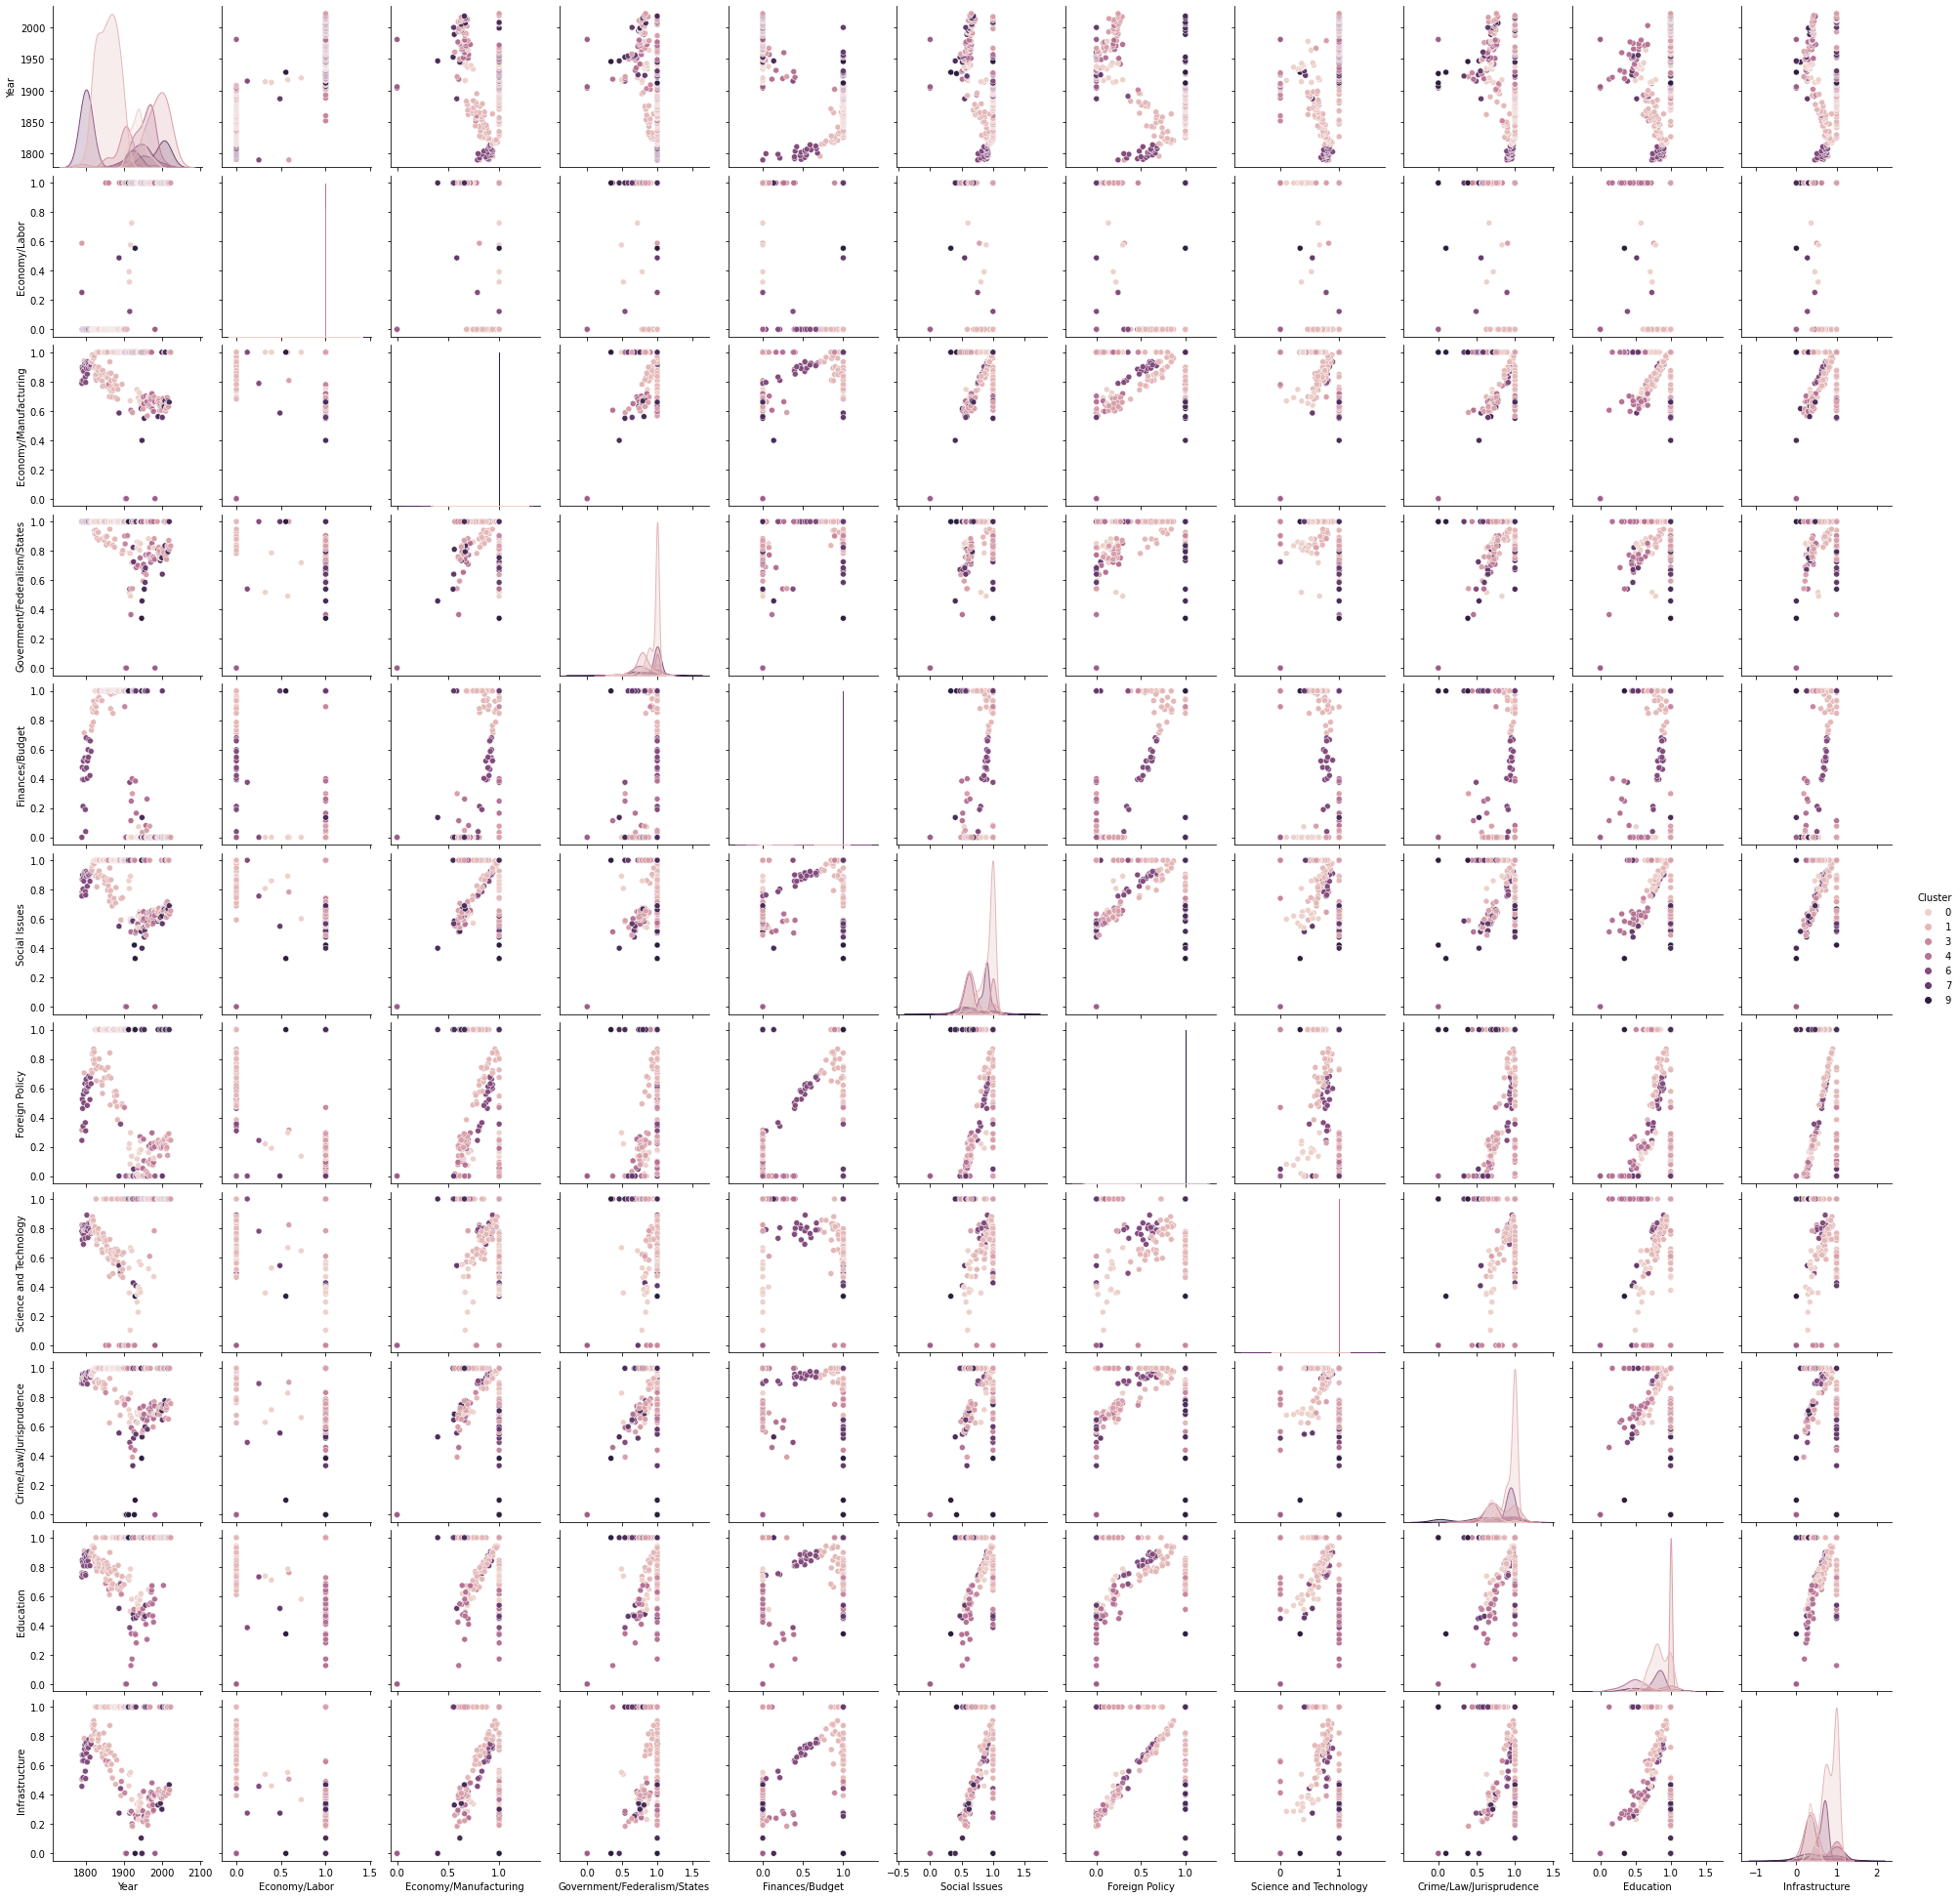

In [50]:
sns.pairplot(df_1, hue='Cluster')

In [51]:
stop_words = stop_words.union(['shall', 'man', 'let', 'know', 'tonight', 'like', 'time', 'world', 'ought', 'new'])

In [52]:
count_vec = CountVectorizer(stop_words=stop_words, ngram_range=(1,3))
tfidf_vec = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,3))

In [53]:
LDA_topics = LatentDirichletAllocation(n_components=1)

In [54]:
# This is really interesting stuff and I wish I had another week to tune this just right but here's my best past with cv and tf-idf for topics on each speech
for i in df.docs_clean:
    ida = count_vec.fit_transform(i)
    larissa = LDA_topics.fit_transform(ida)
    display_topics(LDA_topics, count_vec.get_feature_names_out(), 20)


Topic  0
end, measure, good, regard, object, union, right, respect, necessary, render, information, consideration, provision, proper, receive, session, direct, free, present, particularly

Topic  0
measure, object, commerce, present, citizen, mean, certain, power, circumstance, effect, particularly, particular, attachment, case, law, house, session, union, fellow, requisite

Topic  0
provision, law, object, measure, proper, important, debt, lay, place, necessary, post, act, present, subscription, effect, indians, far, conduct, community, immediate

Topic  0
law, provision, proper, citizen, subject, information, present, service, attention, hostility, tribe, measure, peace, operation, execution, object, want, case, tend, session

Topic  0
military, peace, law, power, executive, citizen, war, present, arm, object, militia, jurisdiction, hand, treaty, individual, representatives, court, house, provision, act

Topic  0
law, citizen, militia, constitution, pennsylvania, power, general, ins

In [55]:
for i in df.docs_clean:
    ida = tfidf_vec.fit_transform(i)
    larissa = LDA_topics.fit_transform(ida)
    display_topics(LDA_topics, tfidf_vec.get_feature_names_out(), 20)


Topic  0
end, measure, good, regard, object, union, right, respect, necessary, render, information, consideration, provision, proper, receive, session, direct, free, present, particularly

Topic  0
measure, object, commerce, present, citizen, mean, certain, power, circumstance, effect, particularly, particular, attachment, case, law, house, session, union, fellow, requisite

Topic  0
provision, law, object, measure, proper, important, debt, lay, place, necessary, post, act, present, subscription, effect, indians, far, conduct, community, immediate

Topic  0
law, provision, present, information, citizen, proper, subject, measure, hostility, peace, attention, service, tribe, operation, event, purpose, execution, consideration, tend, foreign

Topic  0
military, peace, law, power, executive, present, war, citizen, arm, object, militia, jurisdiction, hand, treaty, individual, representatives, court, house, provision, act

Topic  0
law, citizen, militia, constitution, pennsylvania, power, g